## Importing Required Libraries

In [5]:
import os
from pathlib import Path
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# Optional: albumentations for advanced augmentation
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALB_AVAILABLE = True
except:
    ALB_AVAILABLE = False
    print("Albumentations not available. Using basic transforms.")


Albumentations not available. Using basic transforms.


## Configuration Of Seed

In [6]:
class Config:
    seed = 42
    img_size = 128
    batch_size =  4
    epochs = 30
    lr = 1e-4
    num_workers = 4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    save_dir = './checkpoints'
    speckle_denoise = True
    threshold = 0.5

cfg = Config()
os.makedirs(cfg.save_dir, exist_ok=True)

# Seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)


## Spackle Noise Reduction

In [7]:
def lee_filter(image: np.ndarray, size=7):
    img = image.astype(np.float32)
    mean = cv2.blur(img, (size, size))
    mean_sq = cv2.blur(img*img, (size, size))
    variance = mean_sq - mean*mean
    overall_variance = np.mean(variance)
    img_filtered = mean + (np.maximum(variance - overall_variance, 0) / (variance + 1e-8)) * (img - mean)
    return img_filtered

def denoise_if_needed(img: np.ndarray, apply_denoise=True):
    if not apply_denoise:
        return img
    channels = []
    for c in range(img.shape[2]):
        ch = img[..., c]
        chf = lee_filter(ch, size=7)
        chf = np.clip(chf, 0, 255)
        channels.append(chf.astype(np.uint8))
    return np.stack(channels, axis=-1)


## Dataset Class and data preprocessing

In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, images_list, masks_list, img_size=128, augment=False, speckle=False):
        self.images = images_list
        self.masks = masks_list
        self.img_size = img_size
        self.augment = augment
        self.speckle = speckle

        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)

        if ALB_AVAILABLE:
            train_transform_list = [
                A.Resize(self.img_size, self.img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
            ]
            self.train_transform = A.Compose(
                train_transform_list + [
                    A.Normalize(mean=self.mean, std=self.std),
                    ToTensorV2()
                ]
            )
            self.val_transform = A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.Normalize(mean=self.mean, std=self.std),
                ToTensorV2()
            ])
        else:
            import torchvision.transforms.functional as TF
            self.TF = TF

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        # -------- SAFE IMAGE READ --------
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"❌ Cannot read image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"❌ Cannot read mask: {mask_path}")

        mask = (mask > 127).astype(np.uint8)

        if self.speckle:
            img = denoise_if_needed(img, apply_denoise=True)

        # -------- TRANSFORMS --------
        if ALB_AVAILABLE:
            if self.augment:
                augmented = self.train_transform(image=img, mask=mask)
            else:
                augmented = self.val_transform(image=img, mask=mask)

            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0).float()
        else:
            img = cv2.resize(img, (self.img_size, self.img_size))
            mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)


            image = self.TF.to_tensor(img)
            image = self.TF.normalize(image, mean=self.mean, std=self.std)
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask


## Loading Dataset

In [9]:
from pathlib import Path
import os
import cv2

data_dir = r"K:\4-1\infosys\claude_oil_spill\Dataset"   # raw string is safer on Windows


def get_image_mask_pairs(img_dir, mask_dir, mask_suffix="_mask"):
    img_dir = Path(img_dir)
    mask_dir = Path(mask_dir)

    valid_exts = [".png", ".jpg", ".jpeg"]  # avoid tif/tiff issues

    img_files = sorted([f for f in img_dir.iterdir() if f.suffix.lower() in valid_exts])
    mask_files = sorted([f for f in mask_dir.iterdir() if f.suffix.lower() in valid_exts])

    mask_map = {
        f.stem.replace(mask_suffix, ""): f
        for f in mask_files
    }

    images, masks = [], []

    for img in img_files:
        name = img.stem

        if name not in mask_map:
            continue

        mask = mask_map[name]

        # -------- SAFETY CHECK --------
        if cv2.imread(str(img)) is None:
            print(f"⚠ Skipping unreadable image: {img}")
            continue

        if cv2.imread(str(mask), cv2.IMREAD_GRAYSCALE) is None:
            print(f"⚠ Skipping unreadable mask: {mask}")
            continue

        images.append(str(img))
        masks.append(str(mask))

    return images, masks


## Load Datasets

In [10]:
train_imgs, train_masks = get_image_mask_pairs(f"{data_dir}/train/images", f"{data_dir}/train/masks", mask_suffix="_mask")
val_imgs, val_masks = get_image_mask_pairs(f"{data_dir}/val/images", f"{data_dir}/val/masks", mask_suffix="_mask")
test_imgs, test_masks = get_image_mask_pairs(f"{data_dir}/test/images", f"{data_dir}/test/masks", mask_suffix="_mask")

## checking Datasets

In [11]:

print(f"Train: {len(train_imgs)} images, {len(train_masks)} masks")
print(f"Val: {len(val_imgs)} images, {len(val_masks)} masks")
print(f"Test: {len(test_imgs)} images, {len(test_masks)} masks")

Train: 59 images, 59 masks
Val: 20 images, 20 masks
Test: 20 images, 20 masks


In [12]:
train_ds = SegmentationDataset(
    train_imgs,
    train_masks,
    img_size=cfg.img_size,
    augment=True,          # augmentation ONLY for training
    speckle=cfg.speckle_denoise
)

val_ds = SegmentationDataset(
    val_imgs,
    val_masks,
    img_size=cfg.img_size,
    augment=False,
    speckle=cfg.speckle_denoise
)

test_ds = SegmentationDataset(
    test_imgs,
    test_masks,
    img_size=cfg.img_size,
    augment=False,
    speckle=cfg.speckle_denoise
)


# Dataset Loaders

In [13]:
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=0
)


# U-Net Model

In [14]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        for feat in features:
            self.downs.append(self.conv_block(in_channels, feat))
            in_channels = feat
        for feat in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feat*2, feat, kernel_size=2, stride=2))
            self.ups.append(self.conv_block(feat*2, feat))
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)
        self.final = nn.Conv2d(features[0], out_channels, 1)
        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = torch.nn.functional.interpolate(
                        x, size=skip.shape[2:], mode="bilinear", align_corners=False )
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)
        return self.final(x)


# Loss & Metics

In [15]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits).view(logits.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        intersection = (probs * targets).sum(dim=1)
        dice = (2*intersection + self.smooth) / (probs.sum(dim=1) + targets.sum(dim=1) + self.smooth)
        return 1 - dice.mean()

def iou_pytorch(outputs, labels, threshold=0.5):
    outputs = (torch.sigmoid(outputs) > threshold).float()
    labels = labels.float()
    intersection = (outputs * labels).sum(dim=(1,2,3))
    union = (outputs + labels - outputs * labels).sum(dim=(1,2,3))
    return ((intersection + 1e-6)/(union + 1e-6)).mean().item()


# Training the model

In [16]:
import copy
import matplotlib.pyplot as plt
import numpy as np

# Pixel Accuracy Function
def pixel_accuracy(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds) > threshold
    correct = (preds == targets.bool()).float().sum()
    total = torch.numel(preds)
    return (correct / total).item() * 100

# Model Setup
device = cfg.device
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()

# Safe GradScaler for CPU/GPU
scaler = torch.amp.GradScaler(enabled=(device=='cuda'))

best_iou = 0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 7
trigger_times = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

# Store Evaluation Values
train_loss_history = []
val_iou_history = []
val_accuracy_history = []

# Training and Validation

In [17]:
for epoch in range(cfg.epochs):
    model.train()
    running_loss = 0.0

    # ---------------- TRAINING ----------------
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs} - Training", ncols=80):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        # Mixed precision (GPU only)
        with torch.amp.autocast(device_type='cuda', enabled=(device=='cuda')):
            outputs = model(images)
            loss = criterion_bce(outputs, masks) + criterion_dice(outputs, masks)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_iou_list = []
    val_acc_list = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg.epochs} - Validation", ncols=80):
            images = images.to(device)
            masks = masks.to(device)

            with torch.amp.autocast(device_type='cuda', enabled=(device=='cuda')):
                outputs = model(images)

            val_iou_list.append(iou_pytorch(outputs, masks, threshold=cfg.threshold))
            val_acc_list.append(pixel_accuracy(outputs, masks, threshold=cfg.threshold))

    # Average metrics
    val_iou = np.mean(val_iou_list)
    val_accuracy = np.mean(val_acc_list)

    val_iou_history.append(val_iou)
    val_accuracy_history.append(val_accuracy)

    # Print epoch stats
    print(f"Epoch [{epoch+1}/{cfg.epochs}] Train Loss: {epoch_loss:.4f} "
          f"Val IoU: {val_iou:.4f} Val Acc: {val_accuracy:.2f}%")

    # Learning rate scheduler
    scheduler.step(val_iou)

    # ---------------- EARLY STOPPING ----------------
    if val_iou > best_iou:
        best_iou = val_iou
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), os.path.join(cfg.save_dir, 'best_model.pth'))
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/30 - Validation: 100%|████████████████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch [1/30] Train Loss: 1.1980 Val IoU: 0.0009 Val Acc: 21.82%


Epoch 2/30 - Validation: 100%|████████████████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch [2/30] Train Loss: 1.0218 Val IoU: 0.5456 Val Acc: 64.57%


Epoch 3/30 - Validation: 100%|████████████████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch [3/30] Train Loss: 0.9983 Val IoU: 0.7272 Val Acc: 77.59%


Epoch 4/30 - Validation: 100%|████████████████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch [4/30] Train Loss: 0.9080 Val IoU: 0.7365 Val Acc: 79.55%


Epoch 5/30 - Validation: 100%|████████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [5/30] Train Loss: 0.8079 Val IoU: 0.7661 Val Acc: 83.13%


Epoch 6/30 - Validation: 100%|████████████████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch [6/30] Train Loss: 0.7729 Val IoU: 0.6646 Val Acc: 73.95%


Epoch 7/30 - Validation: 100%|████████████████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch [7/30] Train Loss: 0.7497 Val IoU: 0.7740 Val Acc: 82.70%


Epoch 8/30 - Validation: 100%|████████████████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch [8/30] Train Loss: 0.7211 Val IoU: 0.8050 Val Acc: 86.71%


Epoch 9/30 - Validation: 100%|████████████████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch [9/30] Train Loss: 0.7391 Val IoU: 0.8124 Val Acc: 87.88%


Epoch 10/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [10/30] Train Loss: 0.6821 Val IoU: 0.8516 Val Acc: 90.94%


Epoch 11/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [11/30] Train Loss: 0.6616 Val IoU: 0.7961 Val Acc: 84.88%


Epoch 12/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [12/30] Train Loss: 0.6352 Val IoU: 0.8011 Val Acc: 86.59%


Epoch 13/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch [13/30] Train Loss: 0.6375 Val IoU: 0.8470 Val Acc: 90.73%


Epoch 14/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch [14/30] Train Loss: 0.6431 Val IoU: 0.8128 Val Acc: 86.59%


Epoch 15/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [15/30] Train Loss: 0.6160 Val IoU: 0.8156 Val Acc: 87.84%


Epoch 16/30 - Validation: 100%|███████████████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch [16/30] Train Loss: 0.5473 Val IoU: 0.8491 Val Acc: 89.91%


Epoch 17/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [17/30] Train Loss: 0.5691 Val IoU: 0.8547 Val Acc: 90.42%


Epoch 18/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch [18/30] Train Loss: 0.5245 Val IoU: 0.8087 Val Acc: 88.76%


Epoch 19/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch [19/30] Train Loss: 0.5015 Val IoU: 0.8177 Val Acc: 89.48%


Epoch 20/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [20/30] Train Loss: 0.5380 Val IoU: 0.7820 Val Acc: 85.88%


Epoch 21/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [21/30] Train Loss: 0.5018 Val IoU: 0.8050 Val Acc: 87.99%


Epoch 22/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [22/30] Train Loss: 0.5083 Val IoU: 0.8276 Val Acc: 88.96%


Epoch 23/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch [23/30] Train Loss: 0.5016 Val IoU: 0.8199 Val Acc: 89.09%


Epoch 24/30 - Validation: 100%|███████████████████| 5/5 [00:04<00:00,  1.02it/s]

Epoch [24/30] Train Loss: 0.4880 Val IoU: 0.7925 Val Acc: 87.43%
Early stopping triggered.


# FINAL METRICS AFTER TRAINING

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
epochs = np.arange(1, len(train_loss_history)+1)

# ---------------- FINAL METRICS ----------------
final_metrics = {
    'Final Train Loss': train_loss_history[-1],
    'Final Val IoU': val_iou_history[-1],
    'Final Val Accuracy': val_accuracy_history[-1]
}

print(">>>>> FINAL METRICS <<<<<")
for k, v in final_metrics.items():
    if 'Accuracy' in k:
        print(f"{k}: {v:.2f}%")
    else:
        print(f"{k}: {v:.4f}")
print("_" * 30)

>>>>> FINAL METRICS <<<<<
Final Train Loss: 0.4880
Final Val IoU: 0.7925
Final Val Accuracy: 87.43%
______________________________


# Plotting & Visualization

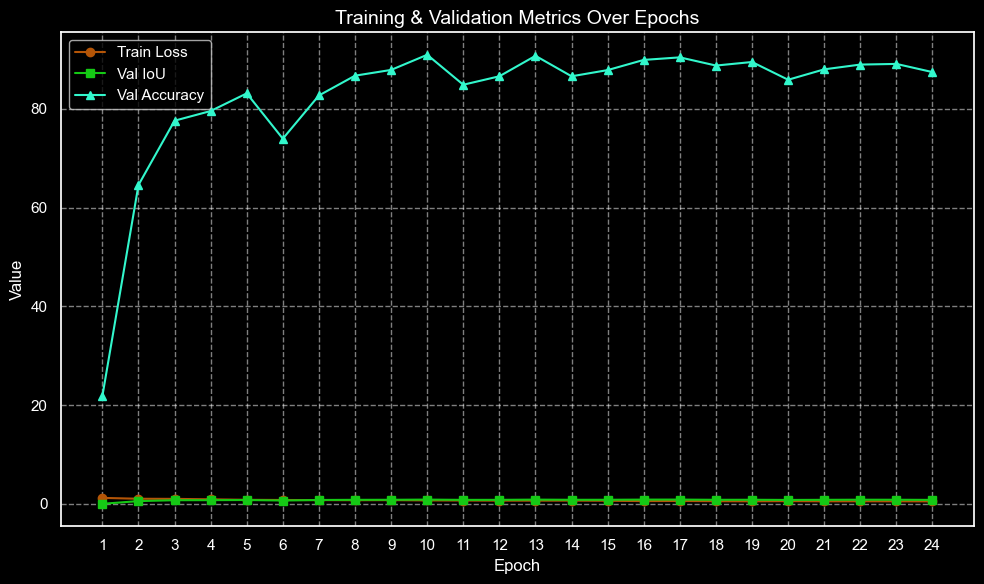

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")
# Epochs
epochs = np.arange(1, len(train_loss_history)+1)

plt.figure(figsize=(10,6))

# Plot Training Loss
plt.plot(epochs, train_loss_history, marker='o', color='#B45507', label='Train Loss')

# Plot Validation IoU
plt.plot(epochs, val_iou_history, marker='s', color='#15C915', label='Val IoU')

# Plot Validation Accuracy
plt.plot(epochs, val_accuracy_history, marker='^', color="#32F7CC", label='Val Accuracy')

plt.title("Training & Validation Metrics Over Epochs", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


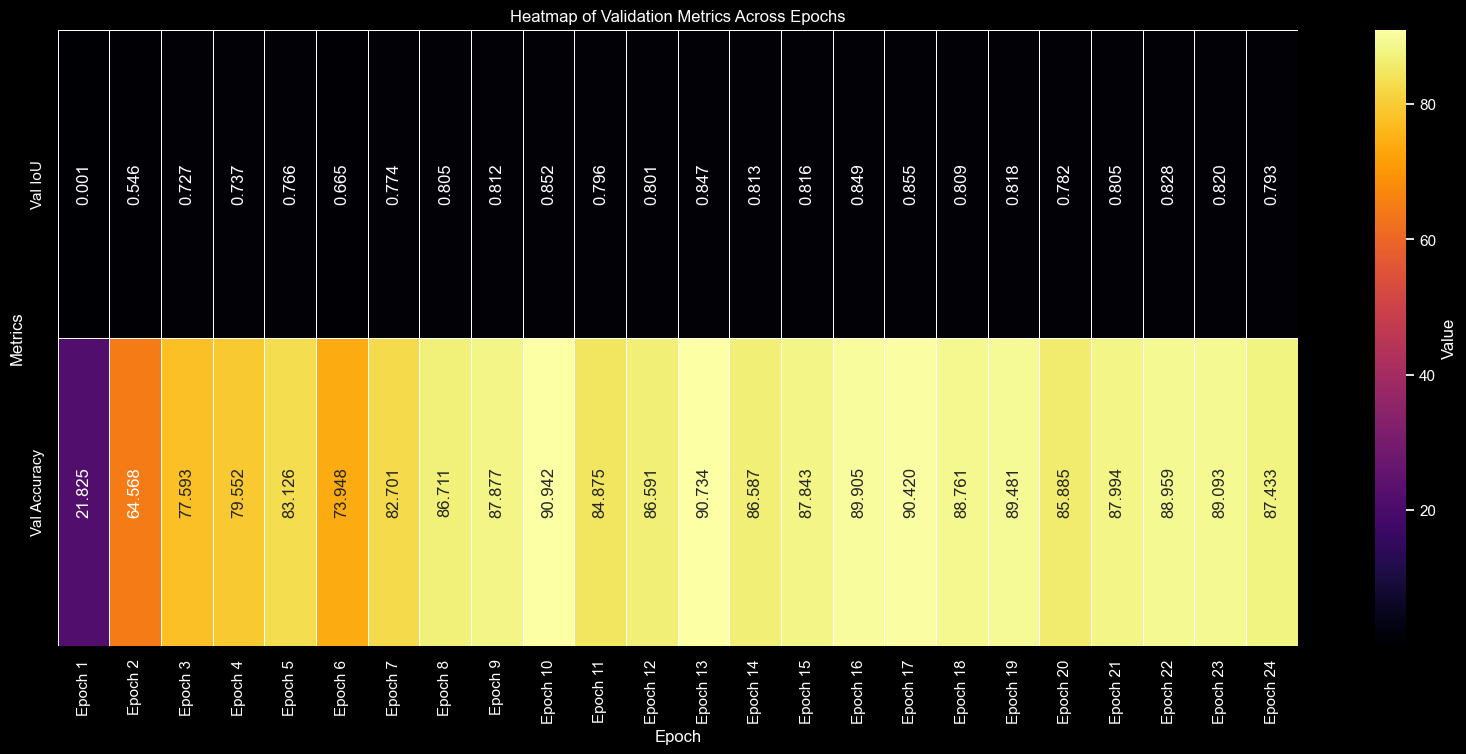

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------------- HEATMAP OF VALIDATION METRICS (Vertical Annotations) ----------------

# Combine metrics into a DataFrame
metrics_df = pd.DataFrame({
    'Val IoU': val_iou_history,
    'Val Accuracy': val_accuracy_history
}, index=[f"Epoch {i+1}" for i in range(len(val_iou_history))])

plt.figure(figsize=(20,8))
sns.heatmap(
    metrics_df.T,              # transpose: metrics as rows, epochs as columns
    annot=True,                # show values in cells
    annot_kws={"rotation":90},# rotate annotation text vertically
    cmap="inferno",               # granate/purple color map
    fmt=".3f",                 # 3 decimal places
    linewidths=0.5,
    cbar_kws={'label': 'Value'}
)
plt.title("Heatmap of Validation Metrics Across Epochs")
plt.ylabel("Metrics")
plt.xlabel("Epoch")
plt.show()


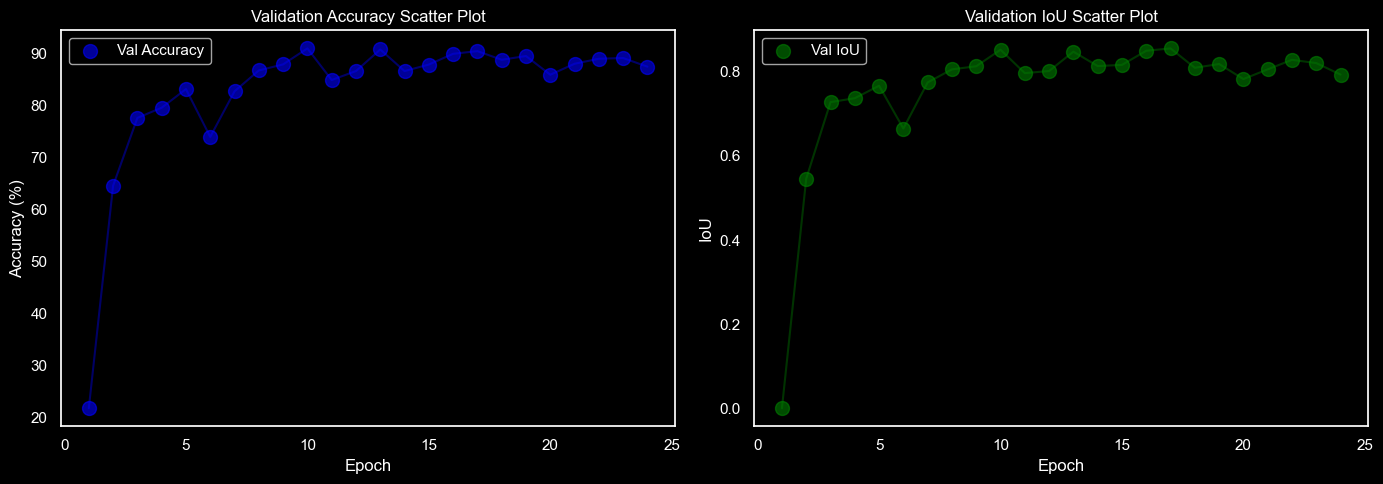

In [21]:

# ---------------- SCATTER PLOTS SIDE BY SIDE ----------------
plt.style.use("dark_background")
fig, axes = plt.subplots(1, 2, figsize=(14,5))  # 1 row, 2 columns

# Validation Accuracy Scatter Plot
axes[0].scatter(epochs, val_accuracy_history, color='blue', s=100, alpha=0.6, label='Val Accuracy')
axes[0].plot(epochs, val_accuracy_history, color='blue', alpha=0.4)
axes[0].set_title('Validation Accuracy Scatter Plot')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend()
axes[0].grid(False)

# Validation IoU Scatter Plot
axes[1].scatter(epochs, val_iou_history, color='green', s=100, alpha=0.6, label='Val IoU')
axes[1].plot(epochs, val_iou_history, color='green', alpha=0.4)
axes[1].set_title('Validation IoU Scatter Plot')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()
axes[1].grid(False) 

plt.tight_layout()
plt.show()

C:\Users\kusar\AppData\Local\Temp\ipykernel_28360\1992066160.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\kusar\AppData\Local\Temp\ipykernel_28360\1992066160.py:11: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  ax = sns.barplot(


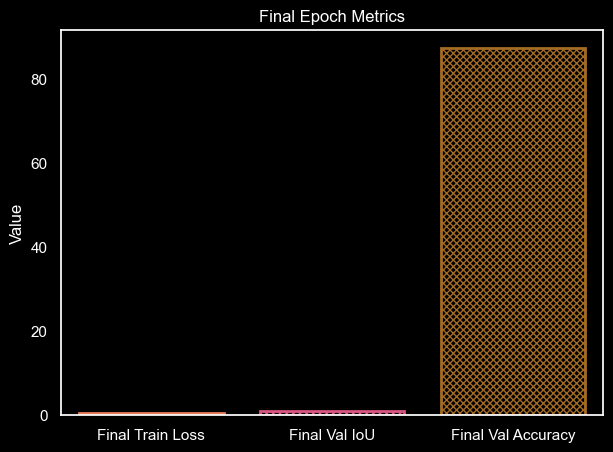

In [22]:
# ---------------- BAR PLOTS ----------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("dark_background")

custom_colors = ["#FF7043", "#EC407A", "#B86E0E", "#BA68C8", "#A1887F", "#FFF176"]

# -------- Vertical Bar Plot --------
plt.figure(figsize=(7,5))
ax = sns.barplot(
    x=list(final_metrics.keys()),
    y=list(final_metrics.values()),
    palette=custom_colors,
    legend=False
)

for bar in ax.patches:
    original_color = bar.get_facecolor()   # ✅ save color first
    bar.set_facecolor('none')               # remove fill
    bar.set_edgecolor(original_color)       # apply saved color
    bar.set_linewidth(2)
    bar.set_hatch('xxxxx')                     # cross hatch

plt.title('Final Epoch Metrics')
plt.ylabel('Value')
plt.grid(False)
plt.show()


C:\Users\kusar\AppData\Local\Temp\ipykernel_28360\3213561209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\kusar\AppData\Local\Temp\ipykernel_28360\3213561209.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  ax = sns.barplot(


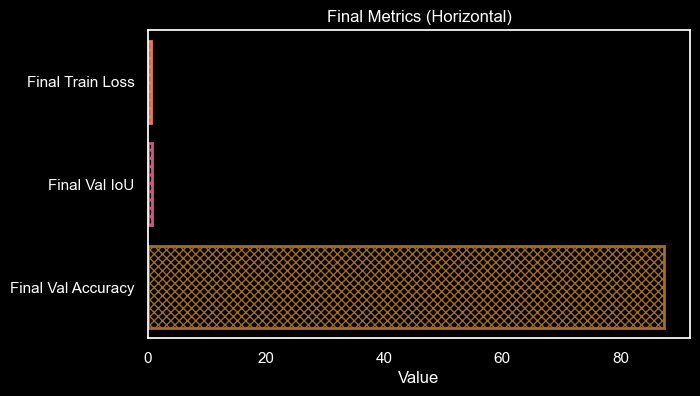

In [23]:

# -------- Horizontal Bar Plot --------
plt.figure(figsize=(7,4))
ax = sns.barplot(
    x=list(final_metrics.values()),
    y=list(final_metrics.keys()),
    palette=custom_colors,
    legend=False
)

for bar in ax.patches:
    original_color = bar.get_facecolor()    # ✅ save color
    bar.set_facecolor('none')
    bar.set_edgecolor(original_color)
    bar.set_linewidth(2)
    bar.set_hatch('xxxx')

plt.title('Final Metrics (Horizontal)')
plt.xlabel('Value')
plt.grid(False)
plt.show()

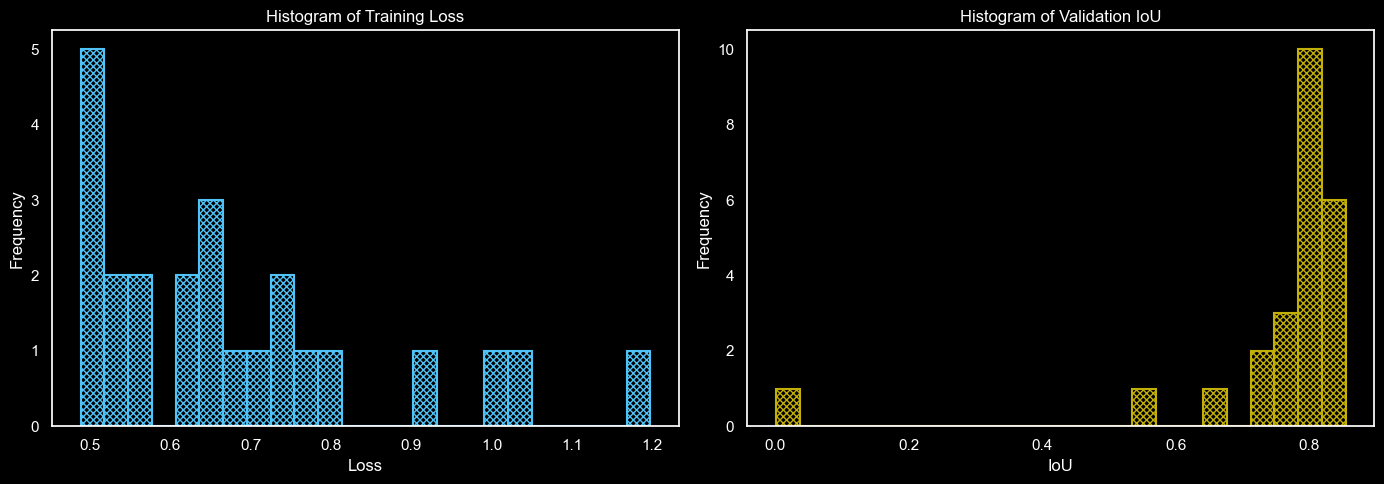

In [24]:
# ---------------- HISTOGRAMS SIDE BY SIDE ----------------
import matplotlib.pyplot as plt

plt.style.use("dark_background")
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Histogram of Training Loss (Cross-hatched)
axes[0].hist(
    train_loss_history,
    bins=len(train_loss_history),
    facecolor='none',          # no solid fill
    edgecolor="#4FC3F7",       # light cyan border
    hatch='xxxxx',                # cross lines
    linewidth=1.5
)
axes[0].set_title('Histogram of Training Loss')
axes[0].set_xlabel('Loss')
axes[0].set_ylabel('Frequency')
axes[0].grid(False)

# Histogram of Validation IoU (Cross-hatched)
axes[1].hist(
    val_iou_history,
    bins=len(val_iou_history),
    facecolor='none',          # no solid fill
    edgecolor="#C2AF07",       # soft green border
    hatch='XXXXX',                # diagonal lines
    linewidth=1.5
)
axes[1].set_title('Histogram of Validation IoU')
axes[1].set_xlabel('IoU')
axes[1].set_ylabel('Frequency')
axes[1].grid(False)

plt.tight_layout()
plt.show()


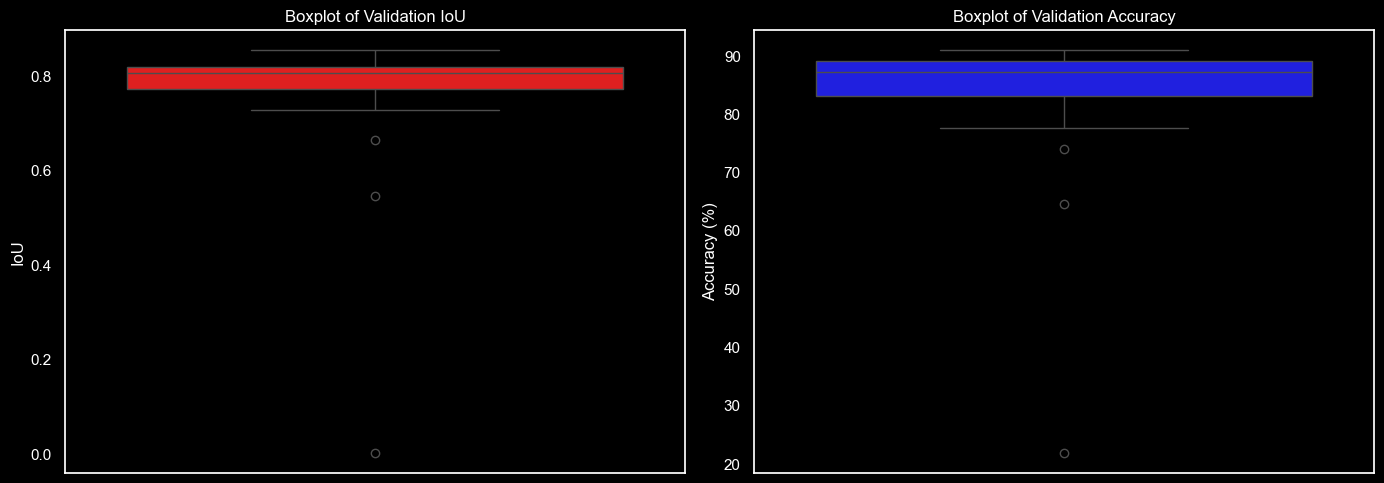

In [25]:

# ---------------- BOXPLOTS SIDE BY SIDE ----------------
plt.style.use("dark_background")
fig, axes = plt.subplots(1, 2, figsize=(14,5))  # 1 row, 2 columns

# Boxplot of Validation IoU
sns.boxplot(data=val_iou_history, color='red', ax=axes[0])
axes[0].set_title('Boxplot of Validation IoU')
axes[0].set_ylabel('IoU')
axes[0].grid(False) 
# Boxplot of Validation Accuracy
sns.boxplot(data=val_accuracy_history, color='blue', ax=axes[1])
axes[1].set_title('Boxplot of Validation Accuracy')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(False) 
plt.tight_layout()
plt.show()

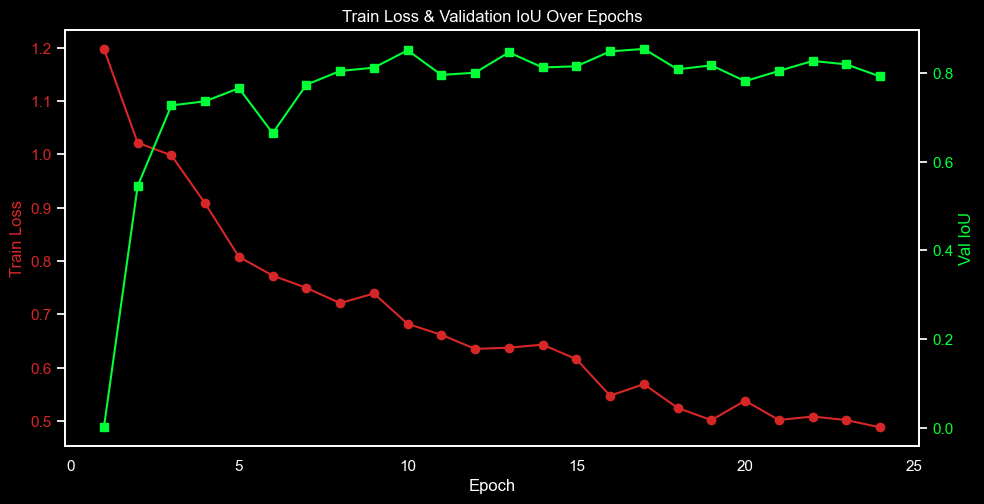

In [26]:
# ---------------- COMBINED BAR + LINE ----------------
plt.style.use("dark_background")
fig, ax1 = plt.subplots(figsize=(10,5))
color1 = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color1)
ax1.plot(epochs, train_loss_history, color=color1, marker='o', label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(False)

ax2 = ax1.twinx()
color2 = "#00FF37"
ax2.set_ylabel('Val IoU', color=color2)
ax2.plot(epochs, val_iou_history, color=color2, marker='s', label='Val IoU')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.grid(False)

fig.tight_layout()
plt.title('Train Loss & Validation IoU Over Epochs')
plt.show()

# Test & visualization


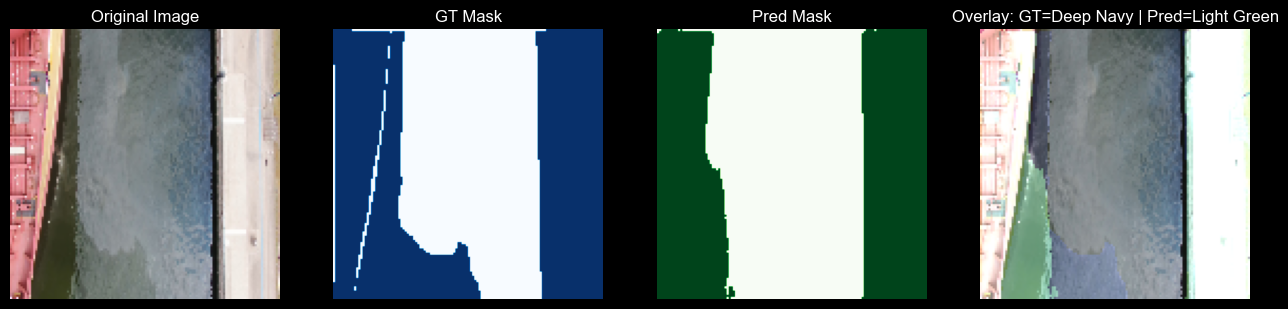

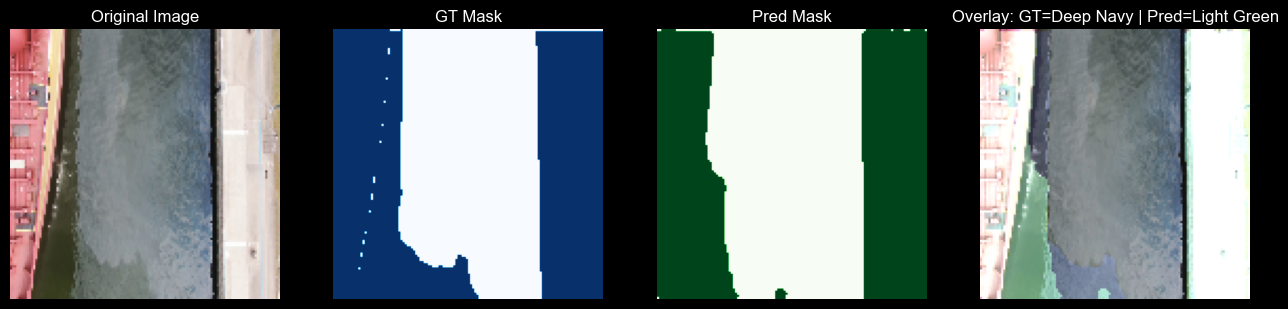

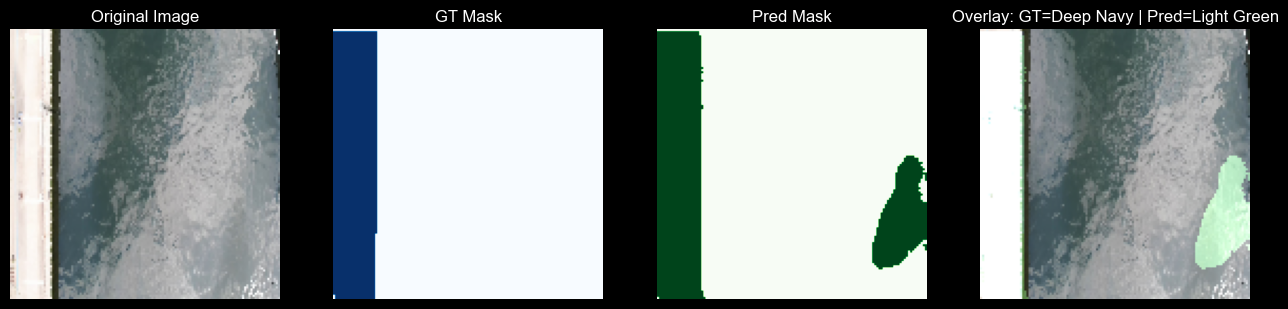

In [27]:
def visualize_predictions_custompalette(model, loader, device, num_images=3):
    """
    Visualizes segmentation with a custom, professional color palette.
    GT = Deep Navy Blue, Pred = Light Green, blended softly over the original image.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Custom colors
    gt_color = np.array([0.05, 0.1, 0.4])    # Deep Navy Blue
    pred_color = np.array([0.5, 0.9, 0.5])   # Light Green
    alpha = 0.4

    model.eval()
    images_shown = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = torch.sigmoid(model(imgs)) > cfg.threshold

            for i in range(imgs.size(0)):
                if images_shown >= num_images:
                    return

                # Denormalize image
                img = imgs[i].cpu().permute(1,2,0).numpy()
                img = (img * std) + mean
                img = np.clip(img, 0, 1)

                mask = masks[i,0].cpu().numpy()
                pred = preds[i,0].cpu().numpy()

                # Create overlay with custom palette
                overlay = img.copy()
                overlay += alpha * mask[...,None] * gt_color
                overlay += alpha * pred[...,None] * pred_color
                overlay = np.clip(overlay, 0, 1)

                plt.figure(figsize=(16,5))
                plt.subplot(1,4,1)
                plt.imshow(img)
                plt.axis('off')
                plt.title("Original Image")

                plt.subplot(1,4,2)
                plt.imshow(mask, cmap='Blues')
                plt.axis('off')
                plt.title("GT Mask")

                plt.subplot(1,4,3)
                plt.imshow(pred, cmap='Greens')
                plt.axis('off')
                plt.title("Pred Mask")

                plt.subplot(1,4,4)
                plt.imshow(overlay)
                plt.axis('off')
                plt.title("Overlay: GT=Deep Navy | Pred=Light Green")

                plt.show()
                images_shown += 1
visualize_predictions_custompalette(model, test_loader, device, num_images=3)

## Manual Testing

In [28]:
def select_image_and_mask_with_accuracy(model, device, img_size=128, threshold=0.4):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import torch
    import tkinter as tk
    from tkinter import filedialog

    # ---------- NORMALIZATION ----------
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    # ---------- COLOR ----------
    PRED_COLOR = np.array([0.40, 0.65, 0.55])
    alpha = 0.45

    # ---------- FILE PICKERS ----------
    root = tk.Tk()
    root.withdraw()

    img_path = filedialog.askopenfilename(
        title="Select Input Image",
        filetypes=[("Images", "*.jpg *.png *.jpeg")]
    )
    if not img_path:
        print("No image selected.")
        return

    mask_path = filedialog.askopenfilename(
        title="Select Ground Truth Mask",
        filetypes=[("Images", "*.jpg *.png *.jpeg")]
    )
    if not mask_path:
        print("No mask selected.")
        return

    # ---------- LOAD IMAGE ----------
    orig = cv2.imread(img_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    h, w = orig.shape[:2]

    # ---------- LOAD MASK ----------
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    ggt_mask = cv2.resize(gt_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    gt_mask = (gt_mask > 127).astype(np.uint8)

    # ---------- PREPROCESS IMAGE ----------
    img = cv2.resize(orig, (img_size, img_size))
    img = img / 255.0
    img = (img - mean) / std

    img_tensor = torch.tensor(img, dtype=torch.float32)
    img_tensor = img_tensor.permute(2,0,1).unsqueeze(0).to(device)

    # ---------- INFERENCE ----------
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)
        prob_map = torch.sigmoid(logits)[0,0].cpu().numpy()

    # ---------- POST-PROCESS ----------
    prob_map = cv2.GaussianBlur(prob_map, (5,5), 0)
    pred_mask = (prob_map > threshold).astype(np.uint8)
    pred_mask = cv2.resize(pred_mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # ---------- METRICS ----------
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    iou = (intersection + 1e-6) / (union + 1e-6)
    pixel_acc = (pred_mask == gt_mask).sum() / gt_mask.size * 100

    print(f"📊 Pixel Accuracy: {pixel_acc:.2f}%")
    print(f"📊 IoU Score: {iou:.4f}")

    # ---------- OVERLAY ----------
    base = orig / 255.0
    base = base * 0.85

    overlay = base.copy()
    overlay += alpha * pred_mask[...,None] * PRED_COLOR
    overlay = np.clip(overlay, 0, 1)

    # ---------- DISPLAY ----------
    plt.figure(figsize=(18,5))

    plt.subplot(1,4,1)
    plt.imshow(orig)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(overlay)
    plt.title("Final Overlay")
    plt.axis("off")

    plt.show()


📊 Pixel Accuracy: 66.93%
📊 IoU Score: 0.6615


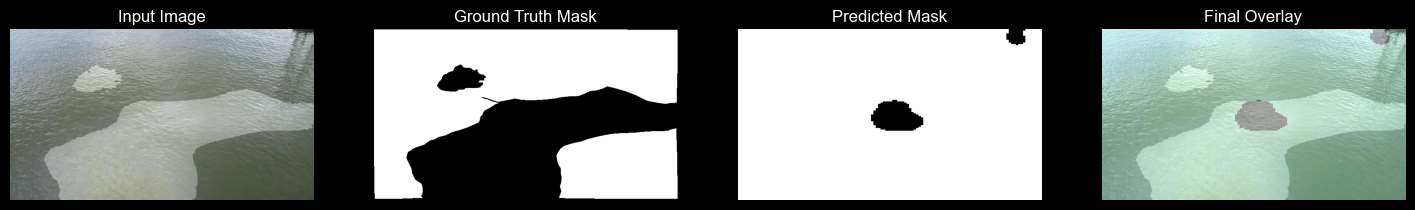

In [29]:
model.load_state_dict(torch.load("./checkpoints/best_model.pth", map_location=device))

select_image_and_mask_with_accuracy(
    model=model,
    device=device,
    img_size=cfg.img_size,
    threshold=0.4
)


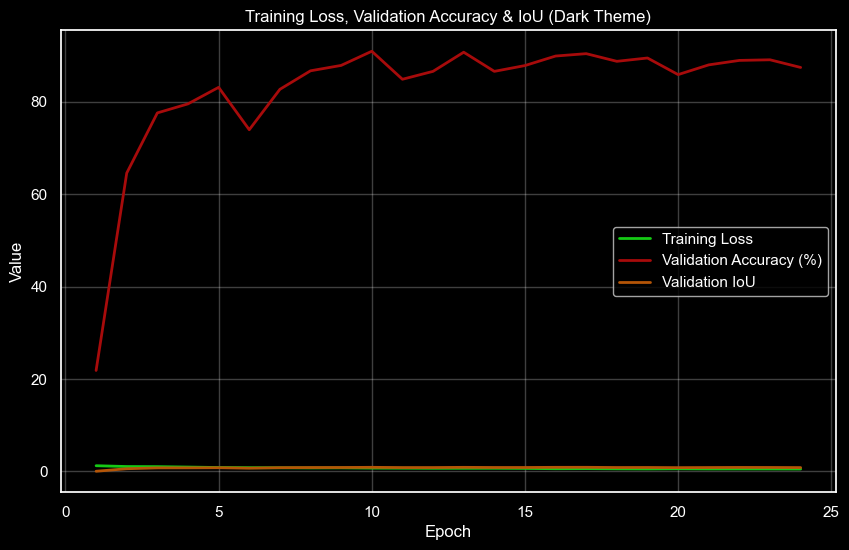

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_history) + 1)

# Dark background
plt.style.use("dark_background")

plt.figure(figsize=(10,6))

# Training Loss – light orange
plt.plot(
    epochs,
    train_loss_history,
    label="Training Loss",
    color="#15C915",   # soft orange
    linewidth=2
)

# Validation Accuracy – light green
plt.plot(
    epochs,
    val_accuracy_history,
    label="Validation Accuracy (%)",
    color="#A70B0B",   # soft green
    linewidth=2
)

# Validation IoU – light cyan
plt.plot(
    epochs,
    val_iou_history,
    label="Validation IoU",
    color="#B45507",   # soft cyan
    linewidth=2
)

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss, Validation Accuracy & IoU (Dark Theme)")
plt.legend()
plt.grid(True, alpha=0.25)

plt.show()


In [31]:
import numpy as np

np.savez(
    "training_metrics.npz",
    train_loss_history=train_loss_history,
    val_iou_history=val_iou_history,
    val_accuracy_history=val_accuracy_history
)
